In [98]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, auc, roc_curve

In [99]:
df = pd.read_csv("marketing_campaign.csv", sep=r"\t")
df

<ipython-input-99-7d60c77480a2>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("marketing_campaign.csv", sep=r"\t")


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,3,0,0,0,0,0,0,3,11,0


In [100]:
def SwapDayAndMonth(date):
    d = date['Dt_Customer'].split('-')
    d[0], d[1] = d[1], d[0]
    res = '-'.join(d)
    return res

df['Dt_Customer'] = df.apply(SwapDayAndMonth,axis=1)
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
today = datetime.datetime.today()
df['Elapsed_Enroll'] = (today - df['Dt_Customer']).dt.days

In [101]:
mask = df['Marital_Status'] == 'Absurd'
df = df[~mask]
mask = df['Marital_Status'] == 'YOLO'
df = df[~mask]
mask = df['Marital_Status'] == 'Alone'
df.loc[mask, 'Marital_Status'] = 'Single'


In [102]:
df = pd.get_dummies(df, columns=['Education','Marital_Status'] )
df.columns

Index(['ID', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer',
       'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Z_CostContact', 'Z_Revenue', 'Response', 'Elapsed_Enroll',
       'Education_2n Cycle', 'Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Marital_Status_Divorced',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Together', 'Marital_Status_Widow'],
      dtype='object')

In [103]:
df = df.drop(['Z_Revenue','Z_CostContact','ID','Dt_Customer'],axis=1)

In [104]:
scaler = StandardScaler()

for column in ['Income','Recency','MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds','NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth','Year_Birth','Elapsed_Enroll']:

    df[column] = scaler.fit_transform(np.array(df[column]).reshape(-1, 1))


In [198]:
df['Complain'].sum()

21

{'whiskers': [<matplotlib.lines.Line2D at 0x1e6c0315b20>,
 'caps': [<matplotlib.lines.Line2D at 0x1e6c01b20a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e6c0315880>],
 'medians': [<matplotlib.lines.Line2D at 0x1e6c01b25e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e6c01b2880>],
 'means': []}

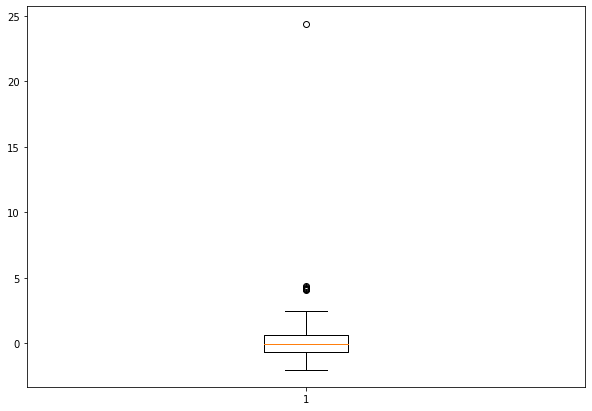

In [169]:
df_na = df.dropna()
fig = plt.figure(figsize =(10, 7))
plt.boxplot(df_na['Income'])
X = df_na.drop('Complain', axis=1)
y = df_na['Complain']

In [112]:
df['Income'] = df['Income'].fillna(df['Income'].median())
X = df.drop('Complain', axis=1)
y = df['Complain']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = .2)


In [113]:
print(sum(y_train))

18


In [114]:
def ploting_the_confusion_matrix(y_test, y_pred_test, labels, unsupervised=True):
  # https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
  matrix = confusion_matrix(y_test, y_pred_test)
  matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]


  # Build the plot
  plt.figure(figsize=(16,7))
  sns.set(font_scale=1.4)
  sns.heatmap(matrix, annot=True, annot_kws={'size':10},
              cmap=plt.cm.Greens, linewidths=0.2)
  print(labels)
  # Add labels to the plot
  class_names = labels
  tick_marks = np.arange(len(class_names))
  tick_marks2 = tick_marks + 0.5
  plt.xticks(tick_marks, class_names, rotation=25)
  plt.yticks(tick_marks2, class_names, rotation=0)
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title('Confusion Matrix')
  plt.show()

In [115]:
def plot_roc_curve(model, x_test, y_test):
    probs = model.predict_proba(x_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [200]:

grid = { 
    'n_estimators': [200,300,400,500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy'],
    'random_state' : [18]
}
rf_cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid, cv= 10)
rf_cv.fit(x_train, y_train)
rf_cv.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 200,
 'random_state': 18}

c:\Users\amirn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy =  0.9866071428571429 
 recall =  0.0 
 precision =  0.0 
 f1 =  0.0
['0', '1']


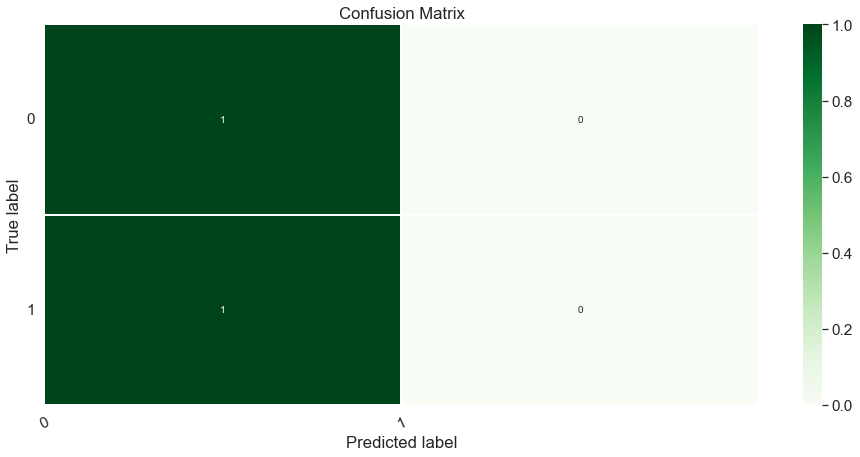

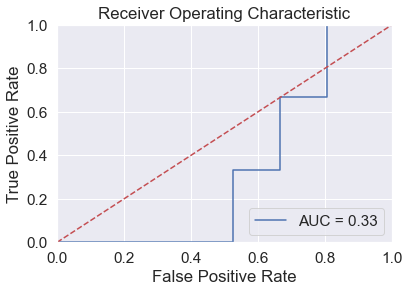

In [67]:
# with dropping nan
rf = RandomForestClassifier(n_estimators = 200, max_depth = 8, max_features = 'sqrt',random_state = 18, criterion = 'gini').fit(x_train, y_train)
prediction = rf.predict(x_test)
print('accuracy = ' , accuracy_score(y_test,prediction) ,
       '\n recall = ', recall_score(y_test,prediction),
       '\n precision = ', precision_score(y_test,prediction),
       '\n f1 = ', f1_score(y_test,prediction))
ploting_the_confusion_matrix(y_test,prediction,['0','1'],unsupervised=False)
plot_roc_curve(rf, x_test, y_test)

c:\Users\amirn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy =  0.9933035714285714 
 recall =  0.0 
 precision =  0.0 
 f1 =  0.0
['0', '1']


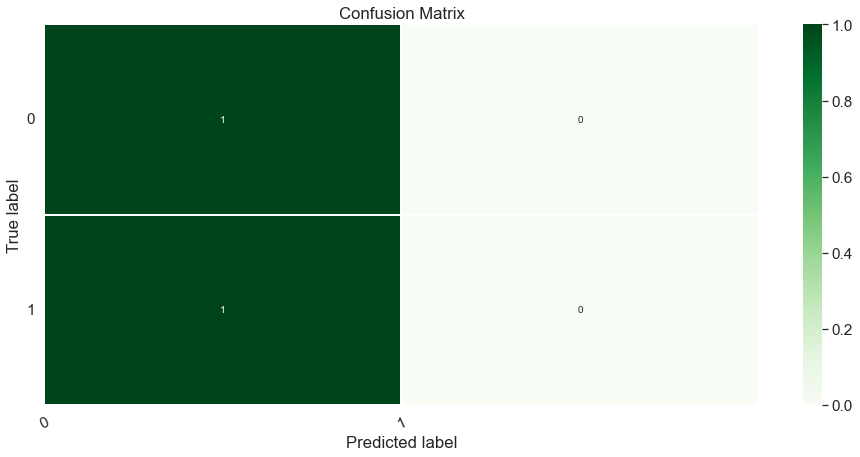

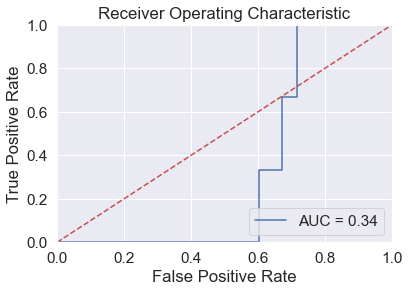

In [116]:
# with median replacement
rf = RandomForestClassifier(n_estimators = 200, max_depth = 8, max_features = 'sqrt',random_state = 18, criterion = 'gini').fit(x_train, y_train)
prediction = rf.predict(x_test)
print('accuracy = ' , accuracy_score(y_test,prediction) ,
       '\n recall = ', recall_score(y_test,prediction),
       '\n precision = ', precision_score(y_test,prediction),
       '\n f1 = ', f1_score(y_test,prediction))
ploting_the_confusion_matrix(y_test,prediction,['0','1'],unsupervised=False)
plot_roc_curve(rf, x_test, y_test)

In [205]:
grid = {
    'criterion':['gini','entropy'],
    'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

clf = GridSearchCV(DecisionTreeClassifier(), grid, cv=10)
clf.fit(x_train, y_train)
clf.best_params_

{'criterion': 'entropy', 'max_depth': 8}

accuracy =  0.9799107142857143 
 recall =  0.0 
 precision =  0.0 
 f1 =  0.0
['0', '1']


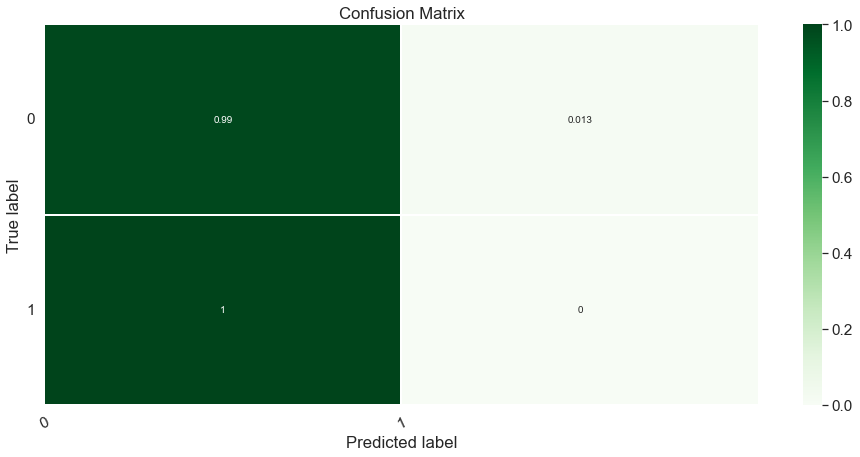

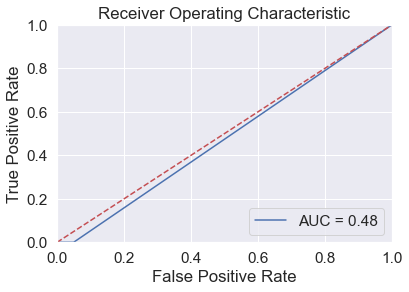

In [117]:
dt = DecisionTreeClassifier(criterion= 'entropy', max_depth= 8).fit(x_train, y_train)
prediction = dt.predict(x_test)
print('accuracy = ' , accuracy_score(y_test,prediction) ,
       '\n recall = ', recall_score(y_test,prediction),
       '\n precision = ', precision_score(y_test,prediction),
       '\n f1 = ', f1_score(y_test,prediction))
ploting_the_confusion_matrix(y_test,prediction,['0','1'],unsupervised=False)
plot_roc_curve(dt, x_test, y_test)

In [208]:
grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf','poly']}

svm = GridSearchCV(SVC(), grid, cv=10) 
svm.fit(x_train, y_train)
svm.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

c:\Users\amirn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy =  0.9933035714285714 
 recall =  0.0 
 precision =  0.0 
 f1 =  0.0
['0', '1']


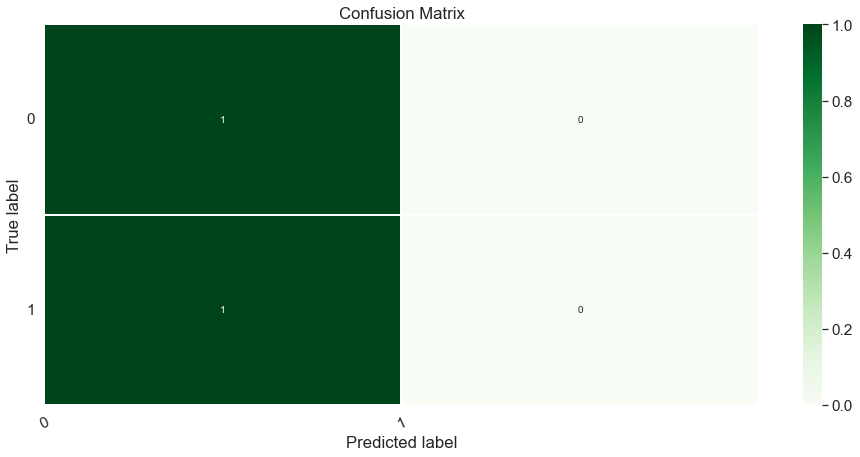

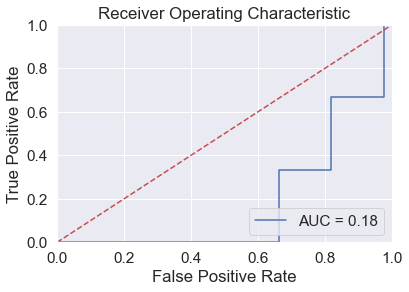

In [118]:
svm = SVC(C= 1, gamma= 1, kernel= 'rbf', probability=True).fit(x_train, y_train)
prediction = svm.predict(x_test)
print('accuracy = ' , accuracy_score(y_test,prediction) ,
       '\n recall = ', recall_score(y_test,prediction),
       '\n precision = ', precision_score(y_test,prediction),
       '\n f1 = ', f1_score(y_test,prediction))
ploting_the_confusion_matrix(y_test,prediction,['0','1'],unsupervised=False)
plot_roc_curve(svm, x_test, y_test)

In [33]:
grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 6),
    "min_samples_leaf": np.linspace(0.1, 0.5, 6),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "squared_error"],
    "subsample":[0.5, 0.8, 0.9, 1.0],
    }
gbc = GridSearchCV(GradientBoostingClassifier(), grid, cv=10) 
gbc.fit(x_train, y_train)
gbc.best_params_

c:\Users\amirn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
43200 fits failed out of a total of 86400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
43200 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\amirn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\amirn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\amirn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ba

{'criterion': 'friedman_mse',
 'learning_rate': 0.01,
 'max_depth': 3,
 'max_features': 'log2',
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.1,
 'subsample': 0.5}

c:\Users\amirn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy =  0.9933035714285714 
 recall =  0.0 
 precision =  0.0 
 f1 =  0.0
['0', '1']


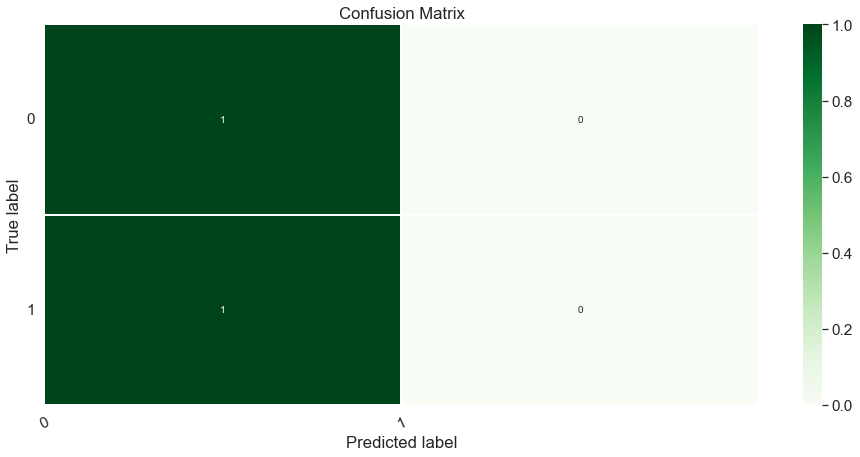

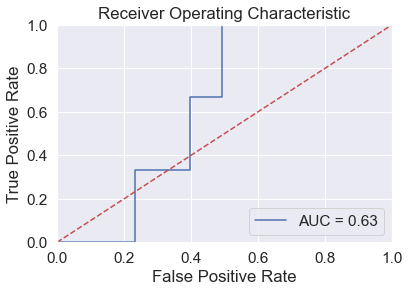

In [119]:
gbc = GradientBoostingClassifier(criterion= 'friedman_mse',
 learning_rate= 0.01,
 max_depth= 3,
 max_features = 'log2',
 min_samples_leaf= 0.1,
 min_samples_split= 0.1,
 subsample= 0.5).fit(x_train, y_train)
prediction = gbc.predict(x_test)
print('accuracy = ' , accuracy_score(y_test,prediction) ,
       '\n recall = ', recall_score(y_test,prediction),
       '\n precision = ', precision_score(y_test,prediction),
       '\n f1 = ', f1_score(y_test,prediction))
ploting_the_confusion_matrix(y_test,prediction,['0','1'],unsupervised=False)
plot_roc_curve(gbc, x_test, y_test)

In [41]:
grid={
'learning_rate': ["constant", "invscaling", "adaptive"],
'hidden_layer_sizes': [(100,1), (100,2), (100,3)],
'alpha': 10.0 ** -np.arange(1, 7),
'activation': ["logistic", "relu", "tanh"]
}
mlp = GridSearchCV(MLPClassifier(), grid, cv=10) 
mlp.fit(x_train, y_train)
mlp.best_params_

c:\Users\amirn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\amirn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\amirn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\amirn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

{'activation': 'logistic',
 'alpha': 0.1,
 'hidden_layer_sizes': (100, 1),
 'learning_rate': 'constant'}

c:\Users\amirn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\amirn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy =  0.9933035714285714 
 recall =  0.0 
 precision =  0.0 
 f1 =  0.0
['0', '1']


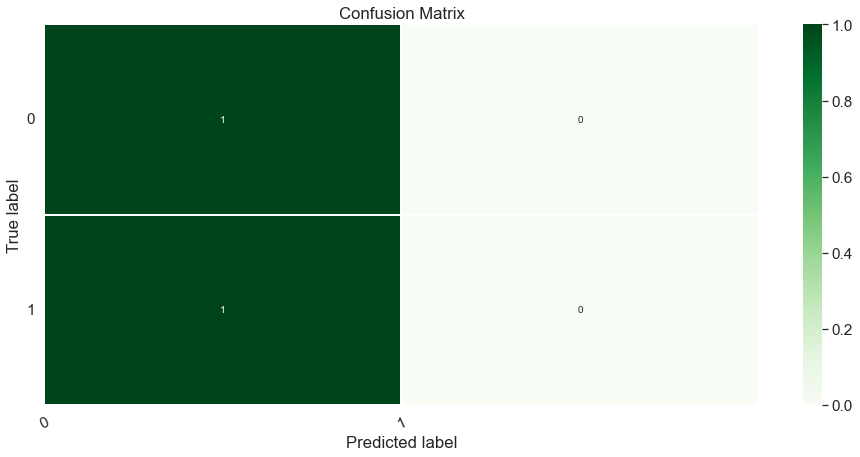

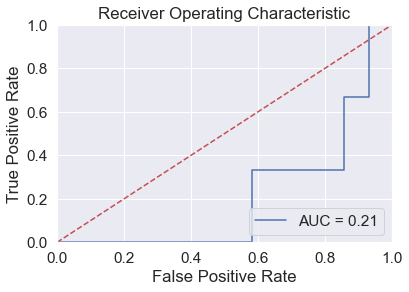

In [120]:
mlp = MLPClassifier(activation = 'logistic',
 alpha = 0.1,
 hidden_layer_sizes = (100, 1),
 learning_rate = 'constant').fit(x_train, y_train)
prediction = mlp.predict(x_test)
print('accuracy = ' , accuracy_score(y_test,prediction) ,
       '\n recall = ', recall_score(y_test,prediction),
       '\n precision = ', precision_score(y_test,prediction),
       '\n f1 = ', f1_score(y_test,prediction))
ploting_the_confusion_matrix(y_test,prediction,['0','1'],unsupervised=False)
plot_roc_curve(mlp, x_test, y_test)

In [45]:
grid = {'n_neighbors': [1,10,1],
        'leaf_size': [20,40,1], 
        'p': [1,2],
        'weights': ['uniform', 'distance']
        }
knn = GridSearchCV(KNeighborsClassifier(), grid, cv=10) 
knn.fit(x_train, y_train)
knn.best_params_

{'leaf_size': 20, 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}

c:\Users\amirn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy =  0.9933035714285714 
 recall =  0.0 
 precision =  0.0 
 f1 =  0.0
['0', '1']


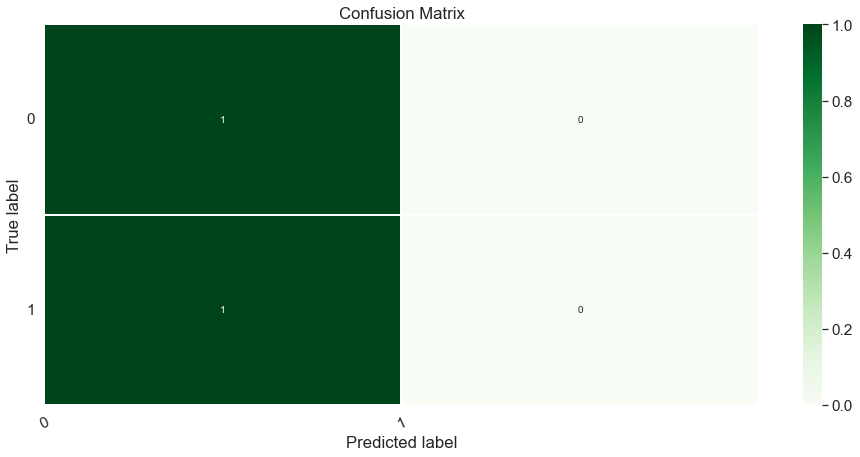

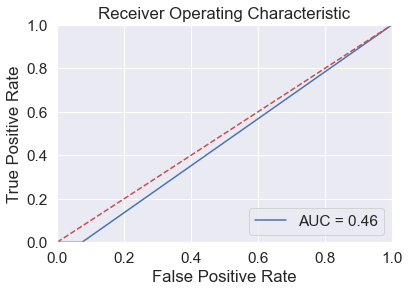

In [121]:
knn = KNeighborsClassifier(leaf_size = 20, n_neighbors = 10, p = 1, weights = 'uniform').fit(x_train, y_train)
prediction = knn.predict(x_test)
print('accuracy = ' , accuracy_score(y_test,prediction) ,
       '\n recall = ', recall_score(y_test,prediction),
       '\n precision = ', precision_score(y_test,prediction),
       '\n f1 = ', f1_score(y_test,prediction))
ploting_the_confusion_matrix(y_test,prediction,['0','1'],unsupervised=False)
plot_roc_curve(knn, x_test, y_test)


In [122]:
grid = { 
    'n_estimators': [200,300,400,500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy'],
    'random_state' : [18]
}
new_grid = {'randomforestclassifier__' + key: grid[key] for key in grid}

kf = KFold(n_splits=10, random_state=42, shuffle=True)
imba_pipeline = make_pipeline(SMOTE(), RandomForestClassifier())
grid_imba = GridSearchCV(imba_pipeline, new_grid, cv=kf, scoring='recall', return_train_score=True)
grid_imba.fit(x_train, y_train)
grid_imba.best_params_

c:\Users\amirn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\amirn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\amirn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\amirn\AppData\Local\Programs\Python\Python38\l